

<center 
class="alert alert-block" 
style="background-color: #313638; 
    color: white;
    padding: 40px;">
<h1>Project 1</h1>
<h2>Brain Tumor MRI Dataset</h2>
<h3>Task 4</h3>


<footer style='text-align: right;'>

</footer>
</center>

Using your previous model from task 2, perform the following:

1.	Visualize and plot training and validation accuracy and loss for each epoch for both models.
2.	Evaluate both models on test set:
a.	Report accuracy, precision, recall and F1-score.
b.	Plot the confusion matrix and interpret the results.
3.	Retrain the models with applied improvement. 
4.	Compare the performance of improved models with the original models using same metrics.
5.	Perform k-fold cross validation on the improved models and evaluate the model’s accuracy, precision, recall and f1 across the different folds.


## Table of Contents

1. [Data Preparation](#data)
2. [Data Visualization](#visualization)
3. [Exploratory Data Analysis](#eda)
4. [Image Preprocessing](#preprocessing)
5. [Binary Classification Model](#binary-classification)
6. [Evaluate Binary Classification Model](#evaluation)
7. [Multi-Class Classification Model](#multi-class-classification)
8. [Evaluate Multi-Class Classification Model](#testing)
<br>
<br>

---

## Preparing environment

In [2]:
# load libraries and set up the environment
import os
from typing import List, Dict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from icecream import ic
import seaborn as sns

from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchsummary import summary
import torchmetrics

from torchsampler import (
    ImbalancedDatasetSampler,
)  # custom sampler for imbalanced dataset

Img = Image.Image

# declare paths for images
dataset_path: str = "./dataset"
train_path: str = os.path.join(dataset_path, "Training")
test_path: str = os.path.join(dataset_path, "Testing")

model2_save_path = "model_5_task4.pth"
model1_save_path = "model_4_task4.pth"

categories: list = os.listdir(train_path)


In [3]:
# check if folder exists
assert os.path.exists(dataset_path)

---
## Data preparation
```
In order to ease data analysis images are converted to pandas dataframe as file paths and their respective metadata
```


<a id="data"></a>

---


In [4]:
def load_all_images(category: str, path: str = train_path) -> Dict[int, str]:
    images: List[str] = os.listdir(os.path.join(path, category))
    results: Dict[int, str] = {}
    for i, image in enumerate(images):
        image_path = os.path.join(path, category, image)
        results.update({i: image_path})
    return results


def create_dataframe(category: str, path: str = train_path) -> pd.DataFrame:
    images = load_all_images(category, path=path).values()
    data: list[dict] = []
    for path in images:
        img: Img = Image.open(path)
        data.append({
            "Path": path,
            "Category": category,
            "Format": img.format,
            "Size": img.size,
            "Mode": img.mode,
        })
    df = pd.DataFrame(data)
    return df


def process_and_save_data(categories: List[str], path: str, output_file: str) -> None:
    frames: List[pd.DataFrame] = []

    for category in categories:
        frames.append(create_dataframe(category, path=path))

    # Merge all dataframes
    merged_df = pd.concat(frames, ignore_index=True)

    # Export df to csv
    merged_df.to_csv(output_file)


if __name__ == "__main__":
    # Create train and test data files in csv format
    process_and_save_data(categories, train_path, "train_data.csv")
    process_and_save_data(categories, test_path, "test_data.csv")

---
## Data visualization
```
Visualize 5 images from dataset for each category
```
<a id="visualization"></a>

---

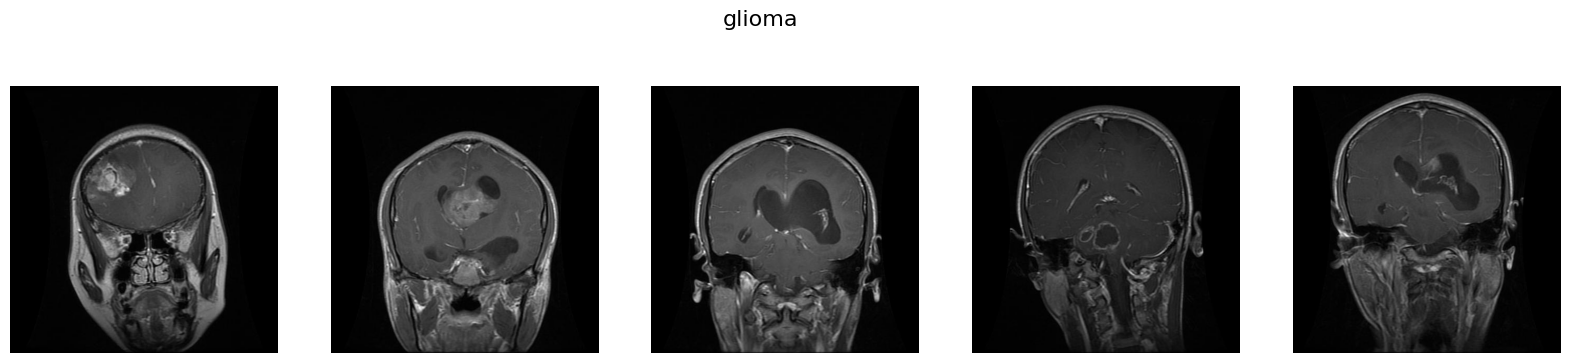

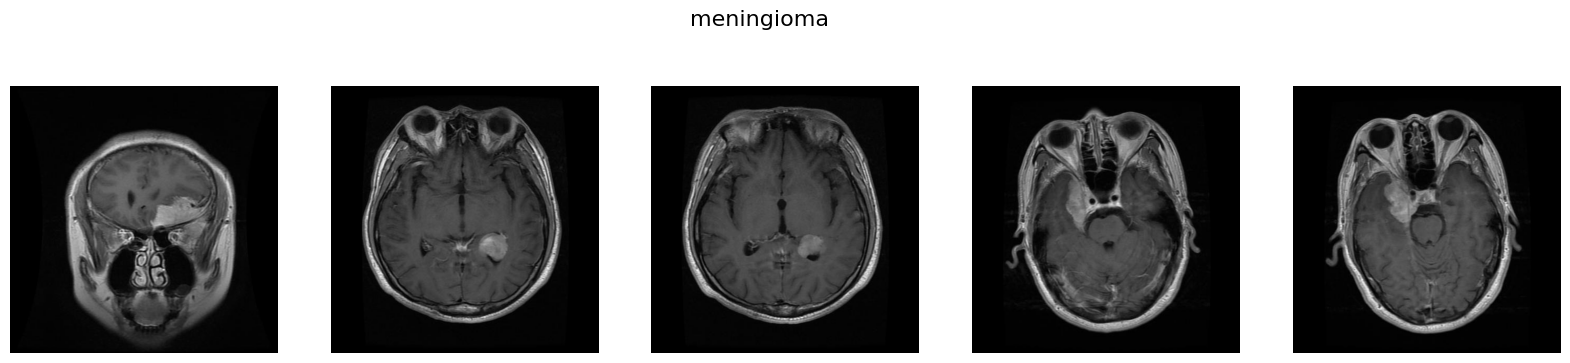

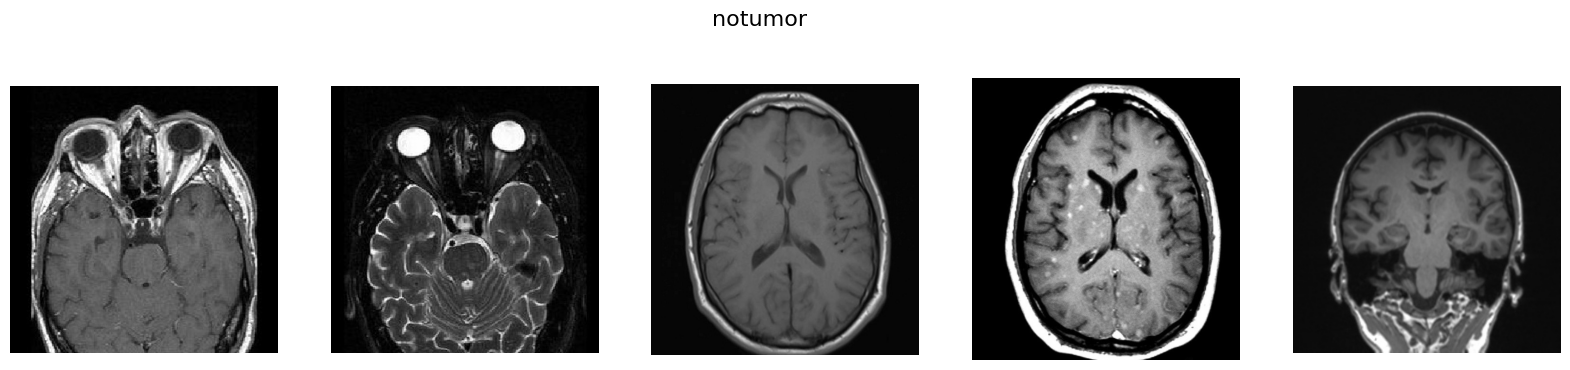

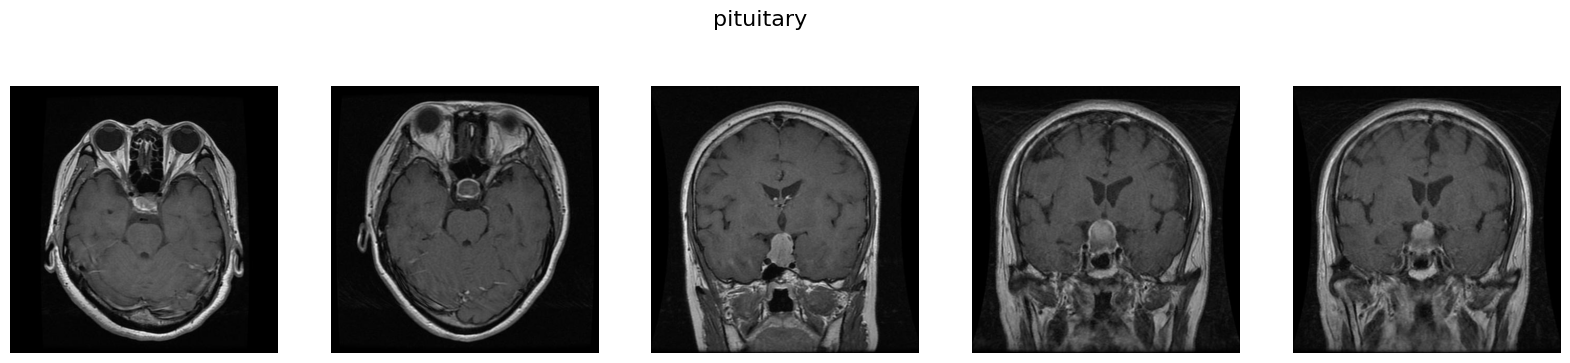

In [5]:
# Function to plot images
def plot_images(category: str) -> None:
    # Filter images by category
    images = df[df["Category"] == category]["Path"].values

    # Create a figure with 5 subplots
    fig, axs = plt.subplots(1, 5, figsize=(20, 20))

    for i, path in enumerate(images[:5]):
        # Open the image using PIL
        img = Image.open(path)
        axs[i].imshow(img)
        axs[i].axis("off")

    # Set a title for the figure
    fig.suptitle(category, fontsize=16, y=0.6)
    plt.show()


if __name__ == "__main__":
    df = pd.read_csv("train_data.csv")

    categories = df["Category"].unique()  # Assuming categories are in the CSV file

    for category in categories:
        plot_images(category)


---
## Exploratory Data Analysis
```
Perform EDA (exploratory data analysis) and report the following:
a. Number of images in each category
b. Image format and size
c. Any potential Class imbalance (eg.Tumor vs no Tumor Count).
```

<a id="eda"></a>

---

ic| df["Category"].value_counts(): Category
                                   notumor       1595
                                   pituitary     1457
                                   meningioma    1339
                                   glioma        1321
                                   Name: count, dtype: int64
ic| df["Format"].value_counts(): Format
                                 JPEG    5707
                                 PNG        5
                                 Name: count, dtype: int64
ic| df["Size"].value_counts(): Size
                               (512, 512)    3955
                               (225, 225)     268
                               (630, 630)      77
                               (236, 236)      53
                               (201, 251)      43
                                             ... 
                               (226, 213)       1
                               (210, 201)       1
                               (235, 264)       1
  

<Axes: xlabel='Category'>

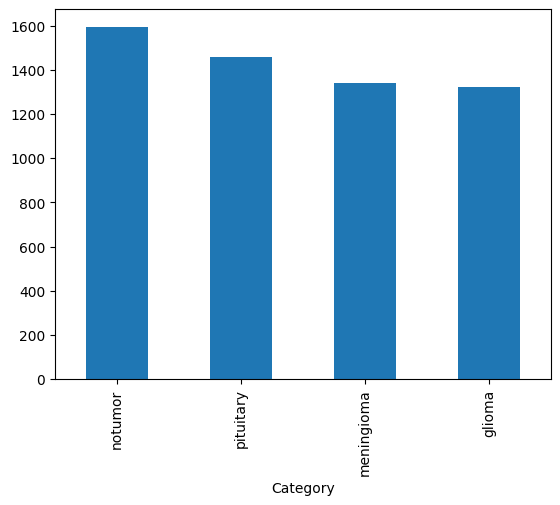

In [6]:
# load csv file
df = pd.read_csv("train_data.csv")

# A
ic(df["Category"].value_counts())

# B
ic(df["Format"].value_counts())
ic(df["Size"].value_counts())
ic(df["Mode"].value_counts())

# C
ic(df["Category"].value_counts().plot(kind="bar"))

---
## Image preprocessing
```
Resize to 128x128
normalize pixels
```

<a id="preprocessing"></a>

---

In [7]:
# Define image transformations
transform_images = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # automatically scales the pixel values to be between 0 and 1
])

---
## Binary Classification Model
```
CNN - Tumor/no Tumor
```

<a id="binary-classification"></a>

---

In [8]:
class Mri_Dataset_1(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = pd.read_csv(dataframe)
        self.paths = self.dataframe["Path"].values
        self.categories = self.dataframe["Category"].values

        # Manually define a mapping from categories to numerical labels
        self.category_to_idx = {
            "glioma": 1,
            "meningioma": 1,
            "notumor": 0,
            "pituitary": 1,
        }

        self.labels = [self.category_to_idx[category] for category in self.categories]
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        # Load the image
        image_path: str = self.paths[idx]
        image: Img = Image.open(image_path).convert("L")

        if self.transform:
            image = self.transform(image)

        # Get the numeric label corresponding to the index
        label = self.category_to_idx[self.categories[idx]]

        return image, label

    def get_labels(self):
        return self.labels

In [9]:
# Prepare data loaders
dataset = Mri_Dataset_1("train_data.csv", transform=transform_images)
train_loader_1 = DataLoader(
    dataset, batch_size=64, sampler=ImbalancedDatasetSampler(dataset)
)  # balances each batch
test_dataset_1 = Mri_Dataset_1("test_data.csv", transform=transform_images)
test_loader_1 = DataLoader(test_dataset_1, batch_size=64, shuffle=True)

In [10]:
class Tumor_model_1(nn.Module):
    def __init__(self):
        super(Tumor_model_1, self).__init__()
        self.conv1 = nn.Conv2d(
            1, 32, kernel_size=3, stride=1
        )  # First convolution layer
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=3, stride=1
        )  # Second convolution layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer

        self.fc1 = nn.Linear(
            64 * 62 * 62, 128
        )  # Input size matches the flattened output
        self.fc2 = nn.Linear(128, 1)  # Single output for binary classification

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)  # Apply ReLU activation
        x = self.conv2(x)
        x = torch.relu(x)  # Apply ReLU activation
        x = self.pool(x)  # Apply pooling
        x = torch.flatten(x, 1)  # Flatten the output
        x = self.fc1(x)
        x = torch.relu(x)  # Apply ReLU activation
        x = self.fc2(x)  # Final output layer
        return x


# Instantiate the model
model = Tumor_model_1()

# Loss function for binary classification with sigmoid output
criterion = nn.BCEWithLogitsLoss()  # has sigmoid function

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Stochastic Gradient Descent


# Display model architecture
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)  # Use GPU if available

model.to(device)  # Ensure the model is on the correct device
print(f"Model loaded from {model2_save_path}")


# Use the torchsummary package to print a summary of the model
summary(model, input_size=(1, 128, 128))


Model loaded from model_5_task4.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]             320
            Conv2d-2         [-1, 64, 124, 124]          18,496
         MaxPool2d-3           [-1, 64, 62, 62]               0
            Linear-4                  [-1, 128]      31,490,176
            Linear-5                    [-1, 1]             129
Total params: 31,509,121
Trainable params: 31,509,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 13.26
Params size (MB): 120.20
Estimated Total Size (MB): 133.52
----------------------------------------------------------------


Training on device: cuda
Epoch [1/10], Training Loss: 0.5331, Validation Loss: 0.3758
Validation Accuracy: 0.8978, Precision: 0.9825, Recall: 0.8675, F1-score: 0.9215
Model saved to model_4_task4.pth with validation loss: 0.3758
Epoch [2/10], Training Loss: 0.1441, Validation Loss: 0.2729
Validation Accuracy: 0.9252, Precision: 0.9927, Recall: 0.8985, F1-score: 0.9432
Model saved to model_4_task4.pth with validation loss: 0.2729
Epoch [3/10], Training Loss: 0.0809, Validation Loss: 0.1326
Validation Accuracy: 0.9596, Precision: 0.9931, Recall: 0.9481, F1-score: 0.9701
Model saved to model_4_task4.pth with validation loss: 0.1326
Epoch [4/10], Training Loss: 0.0499, Validation Loss: 0.1573
Validation Accuracy: 0.9535, Precision: 1.0000, Recall: 0.9327, F1-score: 0.9652
Epoch [5/10], Training Loss: 0.0301, Validation Loss: 0.0703
Validation Accuracy: 0.9809, Precision: 1.0000, Recall: 0.9724, F1-score: 0.9860
Model saved to model_4_task4.pth with validation loss: 0.0703
Epoch [6/10], Tra

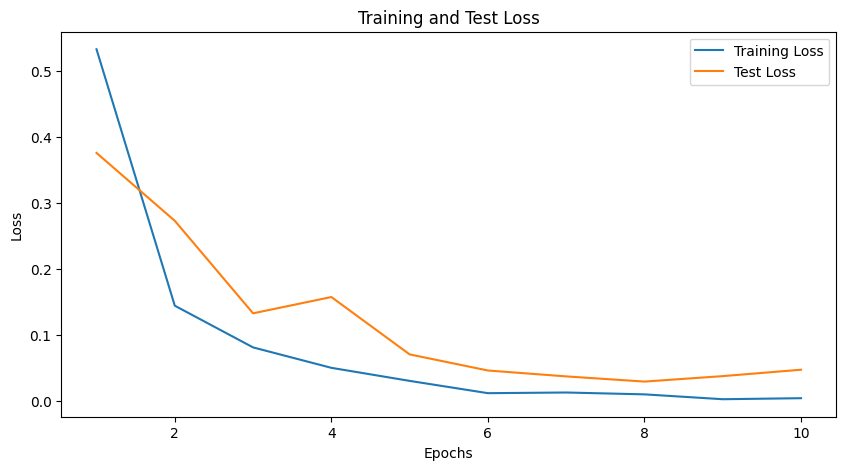

In [11]:
num_epochs = 10
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)  # Use GPU if available
print(f"Training on device: {device}")

model.to(device)  # Move the model to the GPU if available

best_val_loss = float("inf")

train_losses = []
test_losses = []


for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader_1:
        inputs, labels = (
            inputs.to(device),
            labels.to(device),
        )  # Move inputs and labels to the GPU if available

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs)  # Get model predictions
        outputs = outputs.view(-1)  # Flatten the output to match labels shape

        # Calculate loss
        loss = criterion(outputs, labels.float())

        # Backward pass and optimization
        loss.backward()  # Backpropagation - calculate gradients
        optimizer.step()  # Update parameters based on gradients

        running_loss += loss.item()

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader_1:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.view(-1)

            loss = criterion(outputs, labels.float())
            test_loss += loss.item()

            probabilities = torch.sigmoid(outputs)
            preds = (probabilities > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    test_loss /= len(test_loader_1)
    train_loss = running_loss / len(train_loader_1)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = torchmetrics.functional.accuracy(
        torch.tensor(all_preds), torch.tensor(all_labels), task="binary"
    )
    precision = torchmetrics.functional.precision(
        torch.tensor(all_preds), torch.tensor(all_labels), task="binary"
    )
    recall = torchmetrics.functional.recall(
        torch.tensor(all_preds), torch.tensor(all_labels), task="binary"
    )
    f1 = torchmetrics.functional.f1_score(
        torch.tensor(all_preds), torch.tensor(all_labels), task="binary"
    )

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}"
    )

    print(
        f"Validation Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}"
    )

    # Checkpointing
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        torch.save(model.state_dict(), model1_save_path)
        print(
            f"Model saved to {model1_save_path} with validation loss: {test_loss:.4f}"
        )
        # Calculate accuracy, precision, recall, and F1-score for validation set


# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.show()

## Evaluate binary classification model

<a id="evaluation"></a>

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_14208\779081553.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model1_save_path))


Model loaded from model_4_task4.pth
Test Accuracy: 0.9947, Precision: 1.0000, Recall: 0.9923, F1-score: 0.9961
Confusion matrix:


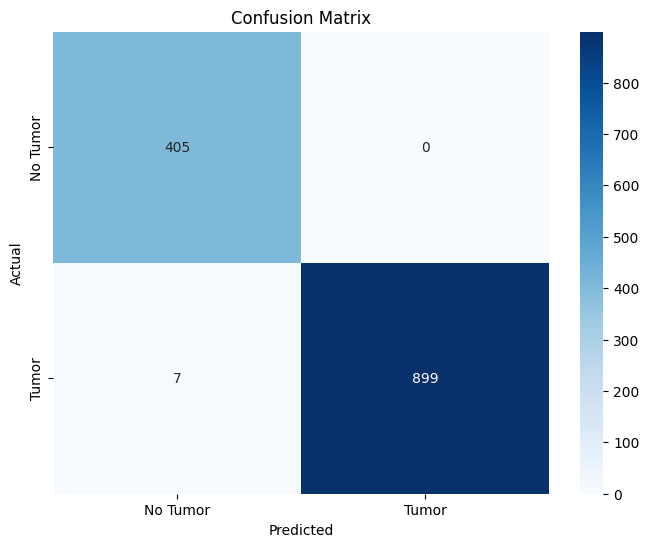

In [12]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)  # Use GPU if available

model = Tumor_model_1()  # Instantiate the model

# Load the model from file
model.load_state_dict(torch.load(model1_save_path))

model.to(device)  # Ensure the model is on the correct device
print(f"Model loaded from {model1_save_path}")

model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []


with torch.no_grad():
    for inputs, labels in test_loader_1:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = outputs.view(-1)
        probabilities = torch.sigmoid(outputs)
        preds = (probabilities > 0.5).float()
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())


# Concatenate all predictions and labels
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

accuracy = torchmetrics.functional.accuracy(
    torch.tensor(all_preds), torch.tensor(all_labels), task="binary"
)
precision = torchmetrics.functional.precision(
    torch.tensor(all_preds), torch.tensor(all_labels), task="binary"
)
recall = torchmetrics.functional.recall(
    torch.tensor(all_preds), torch.tensor(all_labels), task="binary"
)
f1 = torchmetrics.functional.f1_score(
    torch.tensor(all_preds), torch.tensor(all_labels), task="binary"
)

print(
    f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}"
)

# Calculate confusion matrix using torchmetrics
confusion_matrix_metric = torchmetrics.ConfusionMatrix(task="binary", num_classes=2).to(
    device
)
confusion_matrix_metric.update(
    torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device)
)
confusion_matrix = confusion_matrix_metric.compute()
print("Confusion matrix:")

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix.cpu(),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Tumor", "Tumor"],
    yticklabels=["No Tumor", "Tumor"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

---
## Multi-Class Classification Model
```
CNN - create model for rocognizing which tumor it is
```

<a id="multi-class-classification"></a>

---

In [13]:
class Mri_Dataset_2(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = pd.read_csv(dataframe)
        self.paths = self.dataframe["Path"].values
        self.categories = self.dataframe["Category"].values

        # Manually define a mapping from categories to numerical labels
        self.category_to_idx = {
            "glioma": 0,
            "meningioma": 1,
            "notumor": 2,
            "pituitary": 3,
        }

        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        # Load the image
        image_path: str = self.paths[idx]
        image: Img = Image.open(image_path).convert("L")

        if self.transform:
            image = self.transform(image)

        # Get the numeric label corresponding to the index
        label = self.category_to_idx[self.categories[idx]]
        label = torch.tensor(label)

        return image, label

In [14]:
#define data loaders
train_dataset_2 = Mri_Dataset_2("train_data.csv", transform=transform_images)
train_loader_2 = DataLoader(train_dataset_2, batch_size=32, shuffle=True)
test_dataset_2 = Mri_Dataset_2("test_data.csv", transform=transform_images)
test_loader_2 = DataLoader(test_dataset_2, batch_size=32, shuffle=True)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim


class Tumor_model_2(nn.Module):
    def __init__(self):
        super(Tumor_model_2, self).__init__()
        self.conv1 = nn.Conv2d(
            1, 32, kernel_size=3, stride=1
        )  # First convolution layer
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=3, stride=1
        )  # Second convolution layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer

        # The size after the convolutions and pooling
        self.fc1 = nn.Linear(
            64 * 62 * 62, 128
        )  # Input size matches the flattened output
        # Output size matches the number of classes
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)  # Apply ReLU activation
        x = self.conv2(x)
        x = torch.relu(x)  # Apply ReLU activation
        x = self.pool(x)  # Apply pooling
        x = torch.flatten(x, 1)  # Flatten the output
        x = self.fc1(x)
        x = torch.relu(x)  # Apply ReLU activation
        x = self.fc2(x)  # Final output layer
        # no need for softmax as it is combined with the loss function
        return x  # Return raw logits


# Instantiate the model
model = Tumor_model_2()

# Loss function for multi-class classification
# Cross Entropy Loss - uses log-softmax internally
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer


# Display model architecture
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)  # Use GPU if available

model.to(device)  # Ensure the model is on the correct device
print(f"Model loaded from {model2_save_path}")


# Use the torchsummary package to print a summary of the model
summary(model, input_size=(1, 128, 128))

Model loaded from model_5_task4.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]             320
            Conv2d-2         [-1, 64, 124, 124]          18,496
         MaxPool2d-3           [-1, 64, 62, 62]               0
            Linear-4                  [-1, 128]      31,490,176
            Linear-5                    [-1, 4]             516
Total params: 31,509,508
Trainable params: 31,509,508
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 13.26
Params size (MB): 120.20
Estimated Total Size (MB): 133.52
----------------------------------------------------------------


Cache Cleared
Training on device: cuda
Epoch [1/10], Training Loss: 0.7260, Validation Loss: 0.4264
Validation Accuracy: 0.8127, Precision: 0.8171, Recall: 0.8127, F1-score: 0.8004
Model saved to model_5_task4.pth with validation loss: 0.4264
Epoch [2/10], Training Loss: 0.2886, Validation Loss: 0.2781
Validation Accuracy: 0.8894, Precision: 0.8935, Recall: 0.8894, F1-score: 0.8889
Model saved to model_5_task4.pth with validation loss: 0.2781
Epoch [3/10], Training Loss: 0.1554, Validation Loss: 0.1707
Validation Accuracy: 0.9336, Precision: 0.9350, Recall: 0.9336, F1-score: 0.9342
Model saved to model_5_task4.pth with validation loss: 0.1707
Epoch [4/10], Training Loss: 0.1059, Validation Loss: 0.2537
Validation Accuracy: 0.8905, Precision: 0.9053, Recall: 0.8905, F1-score: 0.8867
Epoch [5/10], Training Loss: 0.0645, Validation Loss: 0.1742
Validation Accuracy: 0.9447, Precision: 0.9488, Recall: 0.9447, F1-score: 0.9455
Epoch [6/10], Training Loss: 0.0344, Validation Loss: 0.2148
Vali

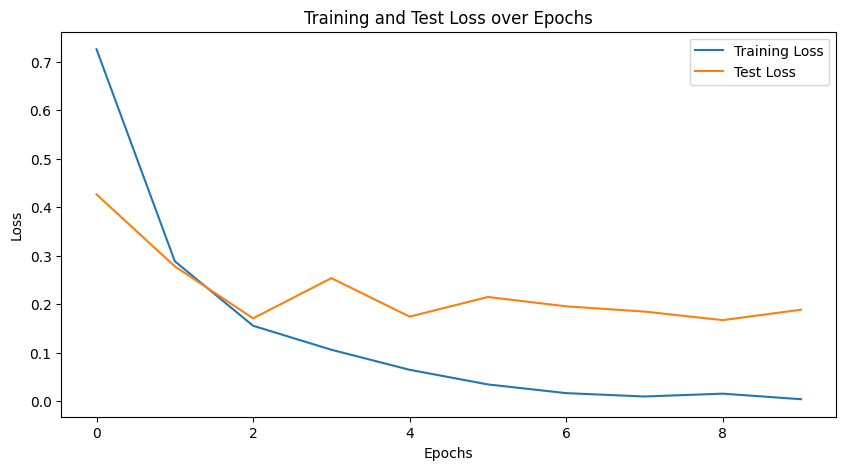

In [16]:
# Train loop

# clear cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Cache Cleared")


# Train the model
num_epochs = 10
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)  # Use GPU if available
print(f"Training on device: {device}")

model.to(device)  # Move the model to the GPU if available

best_val_loss = float("inf")

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader_2:
        inputs, labels = (
            inputs.to(device),
            labels.to(device),
        )  # Move inputs and labels to the GPU if available

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs)  # Get model predictions

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()  # Backpropagation - calculate gradients
        optimizer.step()  # Update parameters based on gradients

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader_2))

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader_2:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    test_loss /= len(test_loader_2)
    test_losses.append(test_loss)

    # Calculate accuracy, precision, recall, and F1-score for validation set
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = torchmetrics.functional.accuracy(
        torch.tensor(all_preds),
        torch.tensor(all_labels),
        task="multiclass",
        num_classes=4,
        average="macro",  # use macro averaging
    )
    precision = torchmetrics.functional.precision(
        torch.tensor(all_preds),
        torch.tensor(all_labels),
        task="multiclass",
        num_classes=4,
        average="macro",
    )
    recall = torchmetrics.functional.recall(
        torch.tensor(all_preds),
        torch.tensor(all_labels),
        task="multiclass",
        num_classes=4,
        average="macro",
    )
    f1 = torchmetrics.functional.f1_score(
        torch.tensor(all_preds),
        torch.tensor(all_labels),
        task="multiclass",
        num_classes=4,
        average="macro",
    )

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader_2):.4f}, Validation Loss: {test_loss:.4f}"
    )
    print(
        f"Validation Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}"
    )

    # Checkpointing
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        torch.save(model.state_dict(), model2_save_path)
        print(
            f"Model saved to {model2_save_path} with validation loss: {test_loss:.4f}"
        )


# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss over Epochs")
plt.show()

---
## Evaluation Of Multi-Class Classification Model
```
```

<a id="testing"></a>

---

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_14208\2210490162.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model2_save_path))


Model loaded from model_5_task4.pth
Confusion matrix:


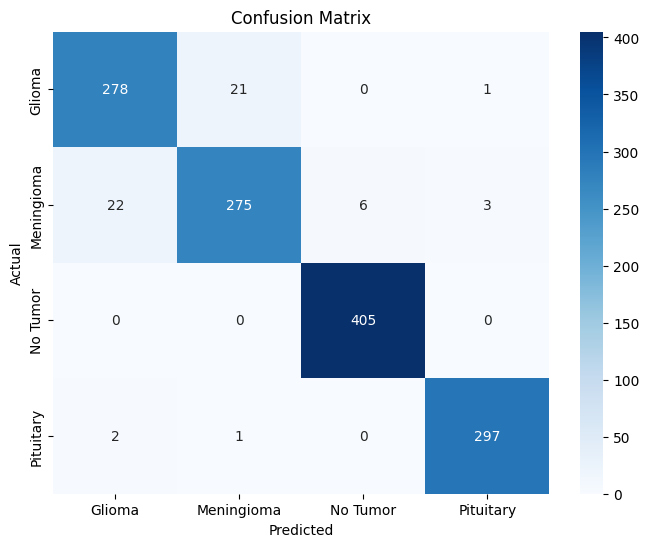

Test Accuracy: 0.9573, Precision: 0.9573, Recall: 0.9573, F1-score: 0.9573


In [17]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)  # Use GPU if available


model = Tumor_model_2()  # Instantiate the model

# Load the model from file
model.load_state_dict(torch.load(model2_save_path))

model.to(device)  # Ensure the model is on the correct device
print(f"Model loaded from {model2_save_path}")

model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []


with torch.no_grad():
    for inputs, labels in test_loader_2:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

accuracy = torchmetrics.functional.accuracy(
    torch.tensor(all_preds),
    torch.tensor(all_labels),
    task="multiclass",
    num_classes=4,
)
precision = torchmetrics.functional.precision(
    torch.tensor(all_preds),
    torch.tensor(all_labels),
    task="multiclass",
    num_classes=4,
)
recall = torchmetrics.functional.recall(
    torch.tensor(all_preds),
    torch.tensor(all_labels),
    task="multiclass",
    num_classes=4,
)
f1 = torchmetrics.functional.f1_score(
    torch.tensor(all_preds),
    torch.tensor(all_labels),
    task="multiclass",
    num_classes=4,
)

# Calculate confusion matrix using torchmetrics
confusion_matrix_metric = torchmetrics.ConfusionMatrix(
    task="MULTICLASS", num_classes=4
).to(device)
confusion_matrix_metric.update(
    torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device)
)
confusion_matrix = confusion_matrix_metric.compute()
print("Confusion matrix:")

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix.cpu(),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Glioma", "Meningioma", "No Tumor", "Pituitary"],
    yticklabels=["Glioma", "Meningioma", "No Tumor", "Pituitary"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(
    f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}"
)

# k-fold validation


In [25]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)  # Use GPU if available


# Function to perform k-fold cross-validation
def k_fold_cross_validation(model_class, dataset, k=5):
    kfold = KFold(n_splits=k, shuffle=True)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        # Create data loaders for the current fold
        val_subset = Subset(dataset, val_idx)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        # Initialize the model, loss function, and optimizer
        model = model_class().to(device)
        criterion = (
            nn.CrossEntropyLoss()
            if model_class == Tumor_model_2
            else nn.BCEWithLogitsLoss()
        )

        model.load_state_dict(
            torch.load(model2_save_path)
        ) if model_class == Tumor_model_2 else model.load_state_dict(
            torch.load(model1_save_path)
        )

        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if model_class == Tumor_model_2:
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)
                else:
                    outputs = outputs.view(-1)
                    loss = criterion(outputs, labels.float())
                    probabilities = torch.sigmoid(outputs)
                    preds = (probabilities > 0.5).float()
                val_loss += loss.item()
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        val_loss /= len(val_loader)
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        if model_class == Tumor_model_2:
            accuracy = torchmetrics.functional.accuracy(
                torch.tensor(all_preds),
                torch.tensor(all_labels),
                task="multiclass",
                num_classes=4,
            )
            precision = torchmetrics.functional.precision(
                torch.tensor(all_preds),
                torch.tensor(all_labels),
                task="multiclass",
                num_classes=4,
            )
            recall = torchmetrics.functional.recall(
                torch.tensor(all_preds),
                torch.tensor(all_labels),
                task="multiclass",
                num_classes=4,
            )
            f1 = torchmetrics.functional.f1_score(
                torch.tensor(all_preds),
                torch.tensor(all_labels),
                task="multiclass",
                num_classes=4,
            )
        else:
            accuracy = torchmetrics.functional.accuracy(
                torch.tensor(all_preds), torch.tensor(all_labels), task="binary"
            )
            precision = torchmetrics.functional.precision(
                torch.tensor(all_preds), torch.tensor(all_labels), task="binary"
            )
            recall = torchmetrics.functional.recall(
                torch.tensor(all_preds), torch.tensor(all_labels), task="binary"
            )
            f1 = torchmetrics.functional.f1_score(
                torch.tensor(all_preds), torch.tensor(all_labels), task="binary"
            )

        print(f"Fold {fold + 1}/{k}")
        print(
            f"Validation Loss: {val_loss:.4f}, "
            f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}"
        )

        fold_results.append(
            {
                "fold": fold + 1,
                "val_loss": val_loss,
                "accuracy": accuracy.item(),
                "precision": precision.item(),
                "recall": recall.item(),
                "f1": f1.item(),
            }
        )

    return fold_results


# Perform k-fold cross-validation for both models
print("\nBinary Model Results:")
binary_model_results = k_fold_cross_validation(Tumor_model_1, test_dataset_1, k=5)
print("\nMulti-Class Model Results:")
multi_class_model_results = k_fold_cross_validation(Tumor_model_2, test_dataset_2, k=5)

print("\n\nBinary Model Results:", binary_model_results)
print("Multi-Class Model Results:", multi_class_model_results)


Binary Model Results:


C:\Users\Sebastian\AppData\Local\Temp\ipykernel_14208\1470355135.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(model1_save_path)


Fold 1/5
Validation Loss: 0.0710, Accuracy: 0.9924, Precision: 1.0000, Recall: 0.9891, F1-score: 0.9945
Fold 2/5
Validation Loss: 0.0126, Accuracy: 0.9962, Precision: 1.0000, Recall: 0.9947, F1-score: 0.9973
Fold 3/5
Validation Loss: 0.0286, Accuracy: 0.9962, Precision: 1.0000, Recall: 0.9946, F1-score: 0.9973
Fold 4/5
Validation Loss: 0.0103, Accuracy: 0.9924, Precision: 1.0000, Recall: 0.9887, F1-score: 0.9943
Fold 5/5
Validation Loss: 0.0133, Accuracy: 0.9962, Precision: 1.0000, Recall: 0.9942, F1-score: 0.9971

Multi-Class Model Results:


C:\Users\Sebastian\AppData\Local\Temp\ipykernel_14208\1470355135.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(model2_save_path)


Fold 1/5
Validation Loss: 0.2324, Accuracy: 0.9392, Precision: 0.9392, Recall: 0.9392, F1-score: 0.9392
Fold 2/5
Validation Loss: 0.1043, Accuracy: 0.9580, Precision: 0.9580, Recall: 0.9580, F1-score: 0.9580
Fold 3/5
Validation Loss: 0.1877, Accuracy: 0.9542, Precision: 0.9542, Recall: 0.9542, F1-score: 0.9542
Fold 4/5
Validation Loss: 0.1748, Accuracy: 0.9542, Precision: 0.9542, Recall: 0.9542, F1-score: 0.9542
Fold 5/5
Validation Loss: 0.0612, Accuracy: 0.9809, Precision: 0.9809, Recall: 0.9809, F1-score: 0.9809


Binary Model Results: [{'fold': 1, 'val_loss': 0.07097846145067403, 'accuracy': 0.9923954606056213, 'precision': 1.0, 'recall': 0.989130437374115, 'f1': 0.994535505771637}, {'fold': 2, 'val_loss': 0.012603576314480355, 'accuracy': 0.9961832165718079, 'precision': 1.0, 'recall': 0.9946523904800415, 'f1': 0.9973190426826477}, {'fold': 3, 'val_loss': 0.02856031200563949, 'accuracy': 0.9961832165718079, 'precision': 1.0, 'recall': 0.9945945739746094, 'f1': 0.9972899556159973}, 

#